# Homework 2

## Task 2 Classification on the Telco-churn dataset(40 points)
You can download the dataset and see it’s description at https://www.kaggle.com/blastchar/telco-customer-churn

### Task 2.1 

Visualize the univariate distribution of each continuous feature, and the distribution of the
target.

In [11]:
# Cell for imports.
from IPython.display import display
from IPython.utils import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, KFold)
from sklearn.neighbors import NearestCentroid
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, PowerTransformer, 
                                   OneHotEncoder)
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cell for data loading.

'''Dataset description
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, 
  device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, 
  monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

The raw data contains 7043 rows (customers) and 21 columns (features).

The “Churn” column is our target.
'''

dataset_df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
display(dataset_df.head())

# Finding numeric features
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = []
for col in dataset_df.columns:
    if dataset_df[col].dtype in numeric_dtypes:
        if col != 'Churn':
            numeric_cols.append(col)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


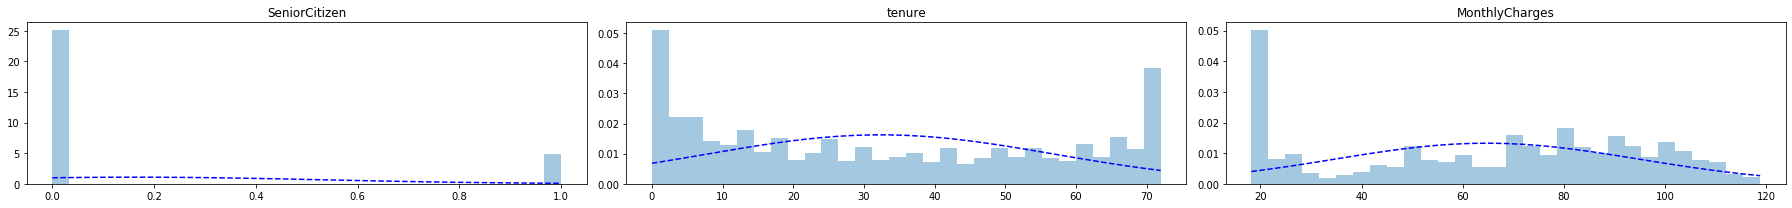

In [4]:
''' Visualize the univariate distribution of each continuous feature, and the distribution of the target. '''
n_cols = 3
n_rows = np.ceil(len(numeric_cols) / n_cols).astype(int)
col_counter = 0
for row_idx in range(n_rows):
    # axes.shape == (n_cols,)
    fig, axes = plt.subplots(1, n_cols, figsize=(25, 3))
    for col_idx in range(n_cols):
        col_name = numeric_cols[col_counter]
        
        # The following code is based on https://zhuanlan.zhihu.com/p/32941723.
        x = dataset_df[col_name]
        mu =np.mean(x)
        sigma =np.std(x)

        n, bins, patches = axes[col_idx].hist(x, bins=30, density=True, alpha=0.4)
        y = norm.pdf(bins, mu, sigma)
        axes[col_idx].plot(bins, y, 'b--')
        
        axes[col_idx].set_title(col_name)
        col_counter += 1
        if col_counter == len(numeric_cols):
            break
plt.tight_layout()

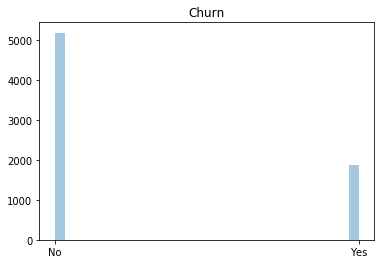

In [5]:
''' Visualize the univariate distribution of target. '''
target = dataset_df['Churn']
plt.hist(target, bins=30, alpha=0.4)
plt.title('Churn')
plt.show()

### Task 2.2
Split data into training and test set. Build a pipeline for dealing with categorical variables.
Evaluate Logistic Regression, linear support vector machines and nearest centroids using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [12]:
model_list = [LogisticRegression(), LinearSVC(), NearestCentroid()]
results_df = pd.DataFrame(columns=['name', 'w scaling', 'w/o scaling'])

# Split data.
X = dataset_df.drop(['Churn'], axis=1)
y = dataset_df['Churn']
print("dataset_df.shape: {}\nX.shape: {}\ny.shape: {}".format(dataset_df.shape, X.shape, y.shape))

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# The following code is based on
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
for idx, model in enumerate(model_list):
    results_score = []
    for use_scaling in [True, False]:
        # OneHotEncoder + ColumnTransformer.
        categorical = X_train.dtypes == object

        categorical_features = categorical[categorical].index
        # To avoid `ValueError: Found unknown categories ['OthW'] in column 26 during transform`,
        # according to 'https://github.com/scikit-learn/scikit-learn/issues/12494', add argument
        # `handle_unknown='ignore'`.
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        numeric_features = categorical[~categorical].index
        if use_scaling:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer()),
                ('scaler', StandardScaler())
            ])
        else:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer())
            ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        # Append classifier to preprocessing pipeline.
        # Now we have a full prediction pipeline.
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])

        scores = cross_val_score(clf, X_train, y_train)
        results_score.append(np.mean(scores))
    results_df.loc[idx] = [type(model).__name__, results_score[0], results_score[1]]
display(results_df)

dataset_df.shape: (7043, 21)
X.shape: (7043, 20)
y.shape: (7043,)


,name,w scaling,w/o scaling
0,LogisticRegression,0.805944,0.797804
1,LinearSVC,0.803671,0.751617
2,NearestCentroid,0.730022,0.721313


### Task 2.3
Tune the parameters using GridSearchCV. Do the results improve?
Visualize the performance as function of the parameters for all three models.

In [13]:
# Split data.
X = dataset_df.drop(['Churn'], axis=1)
y = dataset_df['Churn']
print("dataset_df.shape: {}\nX.shape: {}\ny.shape: {}".format(dataset_df.shape, X.shape, y.shape))

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# models and hyperparameters.
model_list = [
    {
        'model': LogisticRegression(),
        'param_grid': {'classifier__C': np.logspace(-3, 2, 6)}
    }, 
    {
        'model': LinearSVC(),
        'param_grid': {'classifier__C': np.logspace(-3, 2, 6)}
    }, 
    {
        'model': NearestCentroid(),
        'param_grid': {'classifier__shrink_threshold': [0, 0.4, .8]}
    }
]
results_df = pd.DataFrame(columns=['name', 'w scaling', 'w/o scaling'])

# The following code is based on
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
for idx, model_dict in enumerate(model_list):
    model = model_dict['model']
    param_grid = model_dict['param_grid']
    
    results_score = []
    for use_scaling in [True, False]:
        # OneHotEncoder + ColumnTransformer.
        categorical = X_train.dtypes == object

        categorical_features = categorical[categorical].index
        # To avoid `ValueError: Found unknown categories ['OthW'] in column 26 during transform`,
        # according to 'https://github.com/scikit-learn/scikit-learn/issues/12494', add argument
        # `handle_unknown='ignore'`.
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        numeric_features = categorical[~categorical].index
        if use_scaling:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer()),
                ('scaler', StandardScaler())
            ])
        else:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer())
            ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        # Append classifier to preprocessing pipeline.
        # Now we have a full prediction pipeline.
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        grid_search = GridSearchCV(clf, param_grid, cv=10)
        grid_search.fit(X_train, y_train)
        results_score.append(grid_search.best_score_)
    results_df.loc[idx] = [type(model).__name__, results_score[0], results_score[1]]
results_df

dataset_df.shape: (7043, 21)
X.shape: (7043, 20)
y.shape: (7043,)


,name,w scaling,w/o scaling
0,LogisticRegression,0.804237,0.805942
1,LinearSVC,0.803291,0.804616
2,NearestCentroid,0.730212,0.721505


### Task 2.4
Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [14]:
# Split data.
X = dataset_df.drop(['Churn'], axis=1)
y = dataset_df['Churn']
print("dataset_df.shape: {}\nX.shape: {}\ny.shape: {}".format(dataset_df.shape, X.shape, y.shape))

# Split data.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# models and hyperparameters.
model_list = [
    {
        'model': LogisticRegression(),
        'param_grid': {'classifier__C': np.logspace(-3, 2, 6)}
    }, 
    {
        'model': LinearSVC(),
        'param_grid': {'classifier__C': np.logspace(-3, 2, 6)}
    }, 
    {
        'model': NearestCentroid(),
        'param_grid': {'classifier__shrink_threshold': [0, 0.4, .8]}
    }
]
results_df = pd.DataFrame(columns=['name', 'w scaling', 'w/o scaling'])

# The following code is based on
# https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
for idx, model_dict in enumerate(model_list):
    model = model_dict['model']
    param_grid = model_dict['param_grid']
    
    results_score = []
    for use_scaling in [True, False]:
        # OneHotEncoder + ColumnTransformer.
        categorical = X_train.dtypes == object

        categorical_features = categorical[categorical].index
        # To avoid `ValueError: Found unknown categories ['OthW'] in column 26 during transform`,
        # according to 'https://github.com/scikit-learn/scikit-learn/issues/12494', add argument
        # `handle_unknown='ignore'`.
        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        numeric_features = categorical[~categorical].index
        if use_scaling:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer()),
                ('scaler', StandardScaler())
            ])
        else:
            numeric_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer())
            ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

        # Append classifier to preprocessing pipeline.
        # Now we have a full prediction pipeline.
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        kfold_splitter = KFold(n_splits=10, shuffle=True)
        grid_search = GridSearchCV(clf, param_grid, cv=kfold_splitter)
        grid_search.fit(X_train, y_train)
        results_score.append(grid_search.best_score_)
    results_df.loc[idx] = [type(model).__name__, results_score[0], results_score[1]]
results_df

dataset_df.shape: (7043, 21)
X.shape: (7043, 20)
y.shape: (7043,)


,name,w scaling,w/o scaling
0,LogisticRegression,0.806513,0.805766
1,LinearSVC,0.804620,0.804620
2,NearestCentroid,0.731920,0.720743


### Task 2.5
Visualize the coefficients for LogisticRegression and Linear Support Vector Machines using
hyper-parameters that performed well in the grid-search.